In [38]:
## Should have all the same signal processing functions from the signal package in R:
## https://cran.r-project.org/web/packages/signal/signal.pdf
from scipy.signal import butter, lfilter

## https://docs.scipy.org/doc/scipy/reference/signal.html

import pandas as pd
import numpy as np
import csv
import glob
import matplotlib.pyplot as plt
import datetime

In [39]:
file_path = r'/Users/dancohen/Dropbox/E4 stuff/test data'
output_path = r'/Users/dancohen/Dropbox/E4 stuff/test data/HR_All_Data'
all_folders = glob.glob(file_path + "/PRF*")

In [46]:
def iterate_sample_rate(df_length, fs):
    # returns list of floats starting from zero iterated upward by sample rate
    result = []
    curr_time = 0.0
    result.append(curr_time)
    
    for i in range(df_length-1):
        curr_time += 1.0/fs
        result.append(curr_time)
    return result

In [59]:
def t_0_diff_seconds(t_0, date_time):
    return (date_time - pd.to_datetime(t_0, unit='s', infer_datetime_format = True)).total_seconds()

In [99]:
def normalize_df(start_df, col_label):
    #Make a copy here to prevent chaining assignment in the dataframe
    start_seconds = start_df.iloc[0][1]
    cp = start_df.copy()
    cp[col_label] = start_df.apply(lambda x: x[col_label]-start_seconds, axis=1)
    cp = cp.set_index(col_label)
    return cp

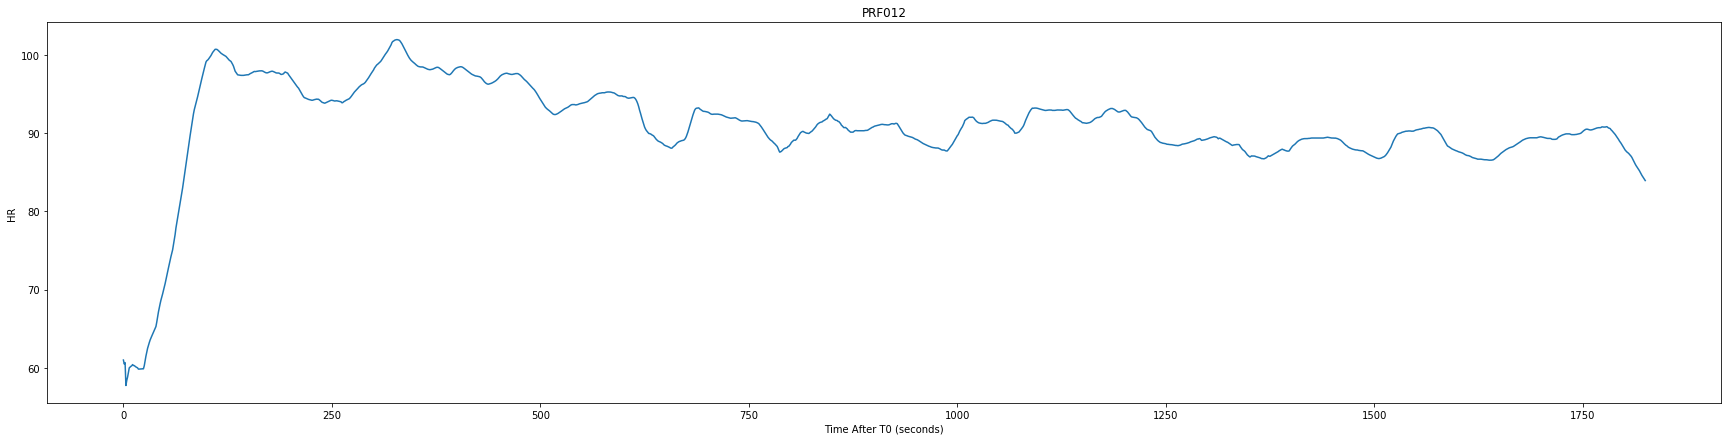

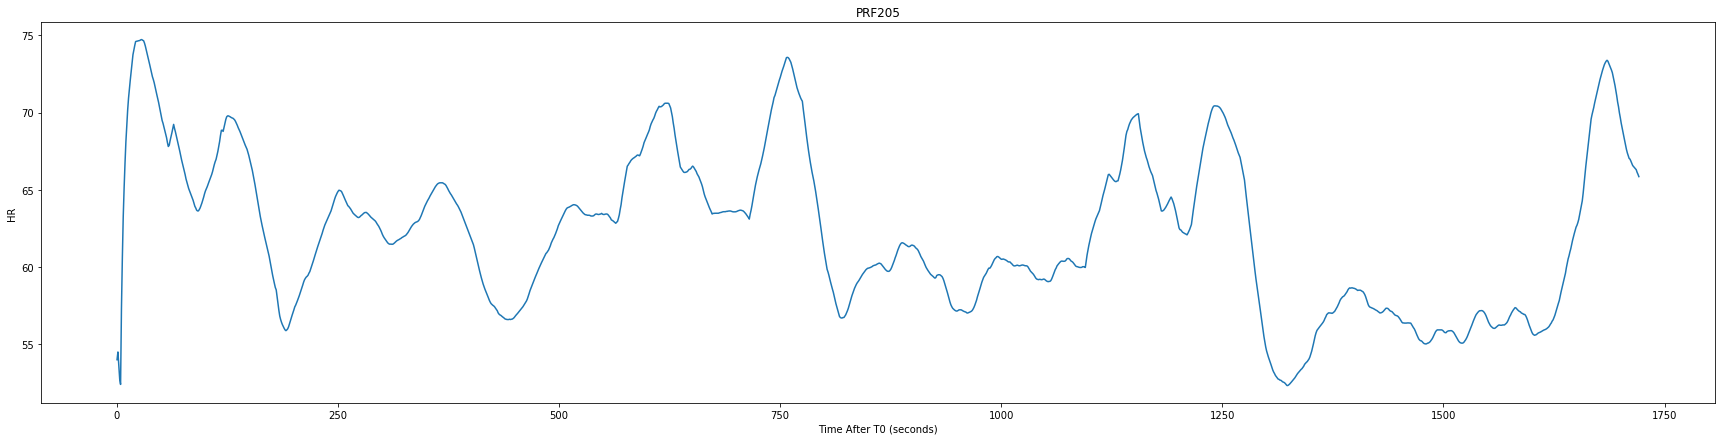

Error occurred parsing tags.csv for PRF020.  Error: 'the label [6] is not in the [index]'. This file will be skipped.


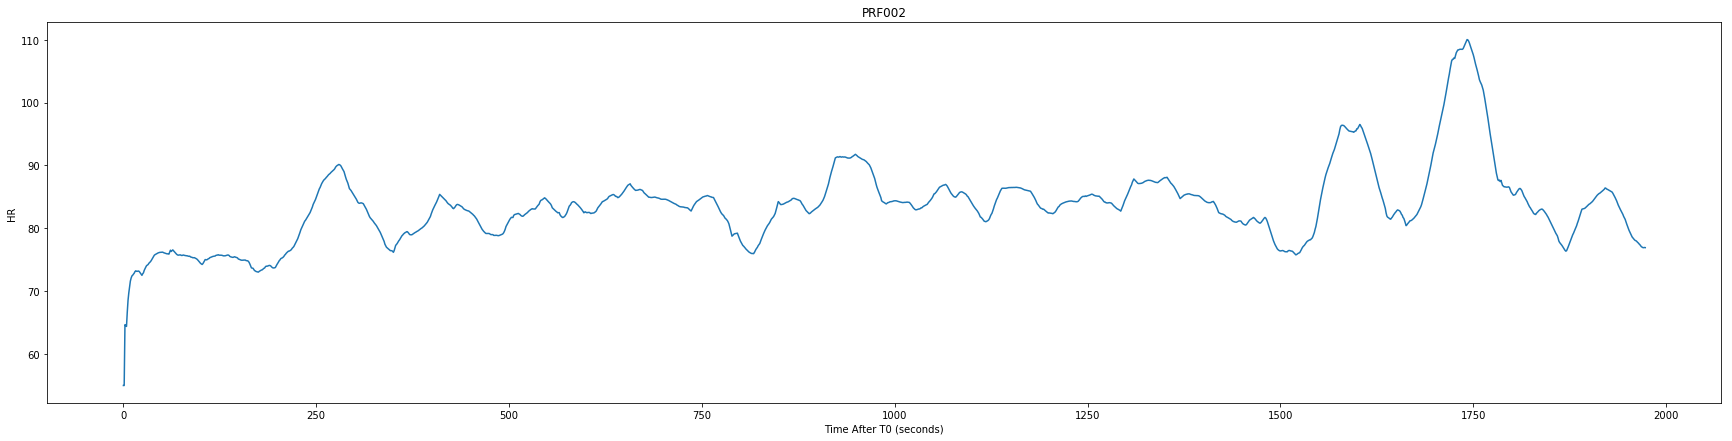

In [110]:
hr_all_part = []
hr_1_2 = []
hr_2_3 = []
hr_3_end = []

for folder in all_folders:
    spl = folder.split('/')
    
    #Folder names are 'PRF###' (participant ID) and we are interested in the ID
    part_id = spl[len(spl)-1][3:]
    
    hr_df_raw = pd.read_csv(folder+"/HR.csv")
    starting_timestamp = hr_df_raw.columns[0]
    sample_rate = hr_df_raw[starting_timestamp][0]
    hr_df_raw = hr_df_raw.drop([0, 0])
    time_col = iterate_sample_rate(len(hr_df_raw), sample_rate)
    hr_df = hr_df_raw.copy()
    hr_df['Timestamp'] = time_col
    hr_df = hr_df.rename(columns={starting_timestamp:part_id})
    
    df_1_2 = hr_df[(hr_df['Timestamp'] >= end_s1) & (hr_df['Timestamp'] < begin_s2)]
    df_1_2 = normalize_df(df_1_2, 'Timestamp')
    df_2_3 = hr_df[(hr_df['Timestamp'] >= end_s2) & (hr_df['Timestamp'] < begin_s3)]
    df_2_3 = normalize_df(df_2_3, 'Timestamp')

    df_3_end = hr_df[(hr_df['Timestamp'] >= end_s3)]
    df_3_end = normalize_df(df_3_end, 'Timestamp')

    hr_df = hr_df.rename(columns={starting_timestamp: part_id})
    hr_df = hr_df.set_index('Timestamp')

    # Grab the csv containing the timestamps that mark the start and end times of the scripts
    script_times = pd.read_csv(folder+"/tags.csv", header=None)
    script_times = script_times.apply(lambda x: pd.to_datetime(x, unit='s'))

    starting_timestamp = hr_df_raw.columns[0]
    
    try:
        begin_s1 = t_0_diff_seconds(starting_timestamp, script_times.loc[1].iat[0])
        end_s1 = t_0_diff_seconds(starting_timestamp, script_times.loc[2].iat[0])
        
        begin_s2 = t_0_diff_seconds(starting_timestamp, script_times.loc[3].iat[0])    
        end_s2 = t_0_diff_seconds(starting_timestamp, script_times.loc[4].iat[0])

        begin_s3 = t_0_diff_seconds(starting_timestamp, script_times.loc[5].iat[0])
        end_s3 = t_0_diff_seconds(starting_timestamp, script_times.loc[6].iat[0])
    except Exception as err:
        print("Error occurred parsing tags.csv for PRF{}.  Error: {}. This file will be skipped.".format(part_id, err))
        continue
    
    plt.figure(figsize=(30, 7))
    plt.plot(time_col, hr_df[part_id] )
    plt.title("PRF{}".format(part_id))
    plt.ylabel('HR')
    plt.xlabel('Time After T0 (seconds)')
    plt.savefig(output_path+"/HR{}.pdf".format(part_id))
    plt.show()
    
    hr_all_part.append(hr_df)
    hr_1_2.append(df_1_2)
    hr_2_3.append(df_2_3)
    hr_3_end.append(df_3_end)

In [111]:
result = pd.concat(hr_all_part, axis=1)

In [112]:
df_1_2 = pd.concat(hr_1_2, axis=1)
df_2_3 = pd.concat(hr_2_3, axis=1)
df_3_end = pd.concat(hr_3_end, axis=1)

In [113]:
df_1_2.to_csv(output_path+"/HR_1_2.csv", float_format='%.6f')
df_2_3.to_csv(output_path+"/HR_2_3.csv", float_format='%.6f')
df_3_end.to_csv(output_path+"/HR_3_end.csv", float_format='%.6f')
result.to_csv(output_path+"/HR_All_Data.csv", float_format='%.6f')